# User Interface and Visualization Node
This node implements an upgraded graphical user interface for the third RT1 assignment. It therefore interacts with two nodes (first_modality_node and secondthird_modality_node) whose task is to realize the control modalities for the robot simulated in Gazebo. In addition to that, this process also help the user visualize some pieces of information regarding the current robot state, by representing them with graphs. In particular the represented quantities are: the robot position, the output of the robot's laser scanners, the number of reached and not reached goals.

## How to run

Run each block of the notebook (it is recommended to run them in order since some declarations present in early blocks are needed to run other blocks)

## Imports
In the following block the necessary libraries, methods and types of data are imported.

In [1]:
import rospy
import time
import functools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
import jupyros as jr
import math
import actionlib
import actionlib.msg
import tf

%matplotlib widget 
#magic function that allows the user to interact with the plots 

from std_msgs.msg import String, Float64, Bool, Float32
from geometry_msgs.msg import Twist
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan
from tf.transformations import quaternion_matrix
from rt2_first_assignment.srv import ChangeMod #import the custom type of service ChangeMod
from rt2_first_assignment.msg import SetGoal #import the custom type of service SetGoal
from matplotlib.animation import FuncAnimation
from ipywidgets import Button,Layout,ButtonStyle,GridBox,interact,interactive,fixed,interact_manual
from IPython.display import display

##  Initialization and global variables
In the following block the node is initialized, the publishers and clients are defined and some global variables are initialized.

In [2]:
rospy.init_node('user_interface_node')
vel_pub = rospy.Publisher('/check_vel',Twist,queue_size=1,latch=True) #publisher that publishes on the topic 
#'/check_vel' a message of type 'Twist' (the latching allows the last sent message to be continuously sent after it
#is sent once)
setgoal_pub = rospy.Publisher('/set_goal',SetGoal,queue_size=1) #publisher that publishes on the topic '/set_goal' 
#a message of custom type 'SetGoal'
changemod_cli1 = rospy.ServiceProxy('/change_mod1',ChangeMod) #client that sends requests belonging to the service 
#'/change_mod1' of type 'ChangeMod'
changemod_cli2 = rospy.ServiceProxy('/change_mod2',ChangeMod) #client that sends requests belonging to the service 
#'/change_mod2' of type 'ChangeMod'
required_vel = Twist() #global message of type 'Twist'
coeff_l = 1.0 #global coefficient that multiplies the linear velocity of the robot
coeff_a = 1.0 #global coefficient that multiplies the angular velocity of the robot

## Real-time visualization class
In the following block a class for the real-time visualization of certain quantities is defined. Specifically, it is aimed at initializing all the graphs and the objects related to them and at generating all the data that are meant to be represented in real-time (robot position, laser scanner's output, number of reached and not reached goals).

In [3]:
class Visualiser:
    def __init__(self): #constructor/method to construct/initialize an instance of the class
        #FIGURES AND AXES INITIALIZATION
        self.fig1, self.ax1 = plt.subplots()
        self.fig2, self.ax2 = plt.subplots()
        self.fig3, self.ax3 = plt.subplots()
        #LINES INITIALIZATION
        self.ln1, = self.ax1.plot([], [], color='blue', marker='*', markersize=12, linewidth=0)
        self.ln2, = self.ax2.plot([], [], color='red', marker='o', markersize=3, linewidth=0)
        self.rects = self.ax3.bar([2,7], [0,0], align='center', width=0.8, color=['green','red'])
        #VARIABLES INITIALIZATION
        self.x_data, self.y_data = [] , [] #initialize two lists to store the x and y value of the robot's position
        self.scan_x_data_rf, self.scan_y_data_rf, self.scan_z_data_rf, self.scan_homo = [] , [] , [], [] #initialize
        #four lists to store the homogeneous coordinates of the points output by the robot's laser scanner in the 
        #current scan
        self.pos_array_rf = np.empty((4,720)) #initialize an array to store all the points output by the robot's 
        #laser scanner in the current scan, projected on the robot frame
        self.pos_array_bf = np.empty((4,720)) #initialize an array to store all the points output by the robot's 
        #laser scanner in the current scan, projected on the odom frame
        self.complete_pos_array_bf = np.empty((4,720)) #initialize an auxiliary array to be filled with the complete 
        #'self.pos_array_bf'
        self.t_matrix = np.identity(4) #initialize an array to store the current transformation matrix from 
        #robot frame to base frame
        self.complete_t_matrix = np.identity(4) #initialize an auxiliary array to be filled with the 
        #complete 'self.t-matrix'
        self.angle = -math.pi/2 #initialize the angle to process the robot's laser scanner output
        self.n_reached_goals = 0 #initialize the variable to be filled with the number of goals reached by the robot
        self.n_notreached_goals = 0 #initialize the variable to be filled with the number of goals not reached by the robot
        self.goals_array = np.empty((2,1)) #initialize an array to store both the number of reached goals and the
        #number of not reached goals
        self.i = 0 #initialize an index to be used in for loops
        self.j = 0
        self.k = 0
        self.h = 0
        
    def plot_init1(self): #method to initialize the first graph
        #GRAPH INITIALIZATION
        self.ln1.set_data([],[]) #initialize the line
        self.ax1.set_xlim(-10, 10) #set the limits of the x-axis
        self.ax1.set_ylim(-10, 10) #set the limits of the y-axis
        self.ax1.set_title("Robot Position") #set the title of the plot
        self.ax1.set_xlabel("x") #set the label of the x-axis
        self.ax1.set_ylabel("y") #set the label of the y-axis
        return self.ln1 #return the line object
    def plot_init2(self): #method to initialize the second graph
        #GRAPH INITIALIZATION
        self.ln2.set_data([],[])
        self.ax2.set_xlim(-10, 10)
        self.ax2.set_ylim(-10, 10)
        self.ax2.set_title("Laser Scan")
        self.ax2.set_xlabel("x")
        self.ax2.set_ylabel("y")
        return self.ln2
    def plot_init3(self): #method to initialize the third graph
        #GRAPH INITIALIZATION
        self.ax3.set_xlim(0, 10)
        self.ax3.set_ylim(0, 10)
        self.ax3.set_title("Goals Status")
        self.ax3.set_ylabel("Number")
        self.ax3.set_xticks([2,7]) #set the ticks along the x axis in correspondence of the bars
        self.ax3.set_xticklabels(['reached goals', 'not reached goals'])
        return self.rects # return the rectangles object
    def clbk_odom(self, msg): #call-back method that is executed every time that a new message is published on 
        #the '/odom' topic. The method is aimed at both retrieving the robot's position that is then represented and
        #at constructing the transformation matrix between the robot frame and the odom frame
        #VARIABLES INITIALIZATION/CLEARING
        self.x_data.clear()
        self.y_data.clear()
        #ROBOT POSITION (wrt the odom frame) APPEND
        self.x_data.append(msg.pose.pose.position.x) #fill the list with x values taken from the odometry topic
        self.y_data.append(msg.pose.pose.position.y) #fill the list with y values taken from the odometry topic
        #TRANSFORMATION MATRIX EVALUATION (starting from quaternion and position wrt the odom frame)
        self.t_matrix = np.identity(4)
        #transform the quaternion vector in a transformation matrix with the rotational part corresponding to 
        #the quaternion
        self.t_matrix = np.array(quaternion_matrix([msg.pose.pose.orientation.x,
                                            msg.pose.pose.orientation.y,
                                            msg.pose.pose.orientation.z,
                                            msg.pose.pose.orientation.w]))
        #fill in the transformation matrix with the rotational part
        self.t_matrix[0,3]= msg.pose.pose.position.x
        self.t_matrix[1,3]= msg.pose.pose.position.y
        self.t_matrix[2,3]= msg.pose.pose.position.z
        
        self.complete_t_matrix=self.t_matrix #save in another matrix the complete 't_matrix' that will be the one
        #processed by the 'clbk_scan'
    def clbk_scan(self, msg): #call-back method that is executed every time that a new message is published on 
        #the '/scan' topic. The method is aimed at processing the output of the robot's laser scanner so as to 
        #obtain a suitable form for the representation
        #VARIABLES INITIALIZATION/CLEARING
        self.step_size = math.pi/len(msg.ranges) #evaluate the step size between the detections of the robot's 
        #laser scanner
        self.angle = -math.pi/2 #initialize the angle to process the robot's laser scanner output
        self.scan_x_data_rf.clear()
        self.scan_y_data_rf.clear()
        self.scan_z_data_rf.clear()
        self.scan_homo.clear()
        self.pos_array_rf = np.empty((4,720))
        self.pos_array_bf = np.empty((4,720))
        self.k = 0
        self.h = self.h+1
        
        if(self.h==15):
            #POLAR-(HOMOGENEOUS)CARTESIAN CONVERSION
            #process the 'ranges' field of the message published on the '/scan' topic and extrapolate the homogeneous 
            #coordinates of the points identified by the robot's laser scanner
            for self.k in range(0, len(msg.ranges)):
                #x-coordinate of the scanned wall at self.angle wrt the robot frame
                self.scan_x_data_rf.append(msg.ranges[self.k]*math.cos(self.angle)) 
                #y-coordinate of the scanned wall at self.angle wrt the robot frame
                self.scan_y_data_rf.append(msg.ranges[self.k]*math.sin(self.angle))
                #z-coordinate of the scanned wall at self.angle wrt the robot frame
                self.scan_z_data_rf.append(0)
                #1 used to realize the homogeneous position representation
                self.scan_homo.append(1)
                self.angle = self.angle + self.step_size
            #ARRAY OF ALL THE CONVERTED POINTS (projected on the robot frame)
            self.pos_array_rf = np.vstack((self.scan_x_data_rf, self.scan_y_data_rf, self.scan_z_data_rf, self.scan_homo))

            #ARRAY OF ALL THE CONVERTED POINTS (projected on the odom frame)
            self.k = 0
            for self.k in range(0, len(msg.ranges)):
                self.pos_array_bf[:, self.k] = np.dot(self.complete_t_matrix, self.pos_array_rf[:, self.k])
            self.complete_pos_array_bf = self.pos_array_bf
            self.h = 0         
    def clbk_goalstatus(self,msg): #call-back method that is executed every time that a new message is published on 
        #the '/goal_status' topic. The method is aimed at keeping track of the reached and not reached goals
        if(msg.data == True):
            print('\033[92m' + 'The goal has been reached' + '\033[0m')
            self.n_reached_goals = self.n_reached_goals+1
        else:
            print('\033[91m' + 'The goal has not been reached' + '\033[0m')
            self.n_notreached_goals = self.n_notreached_goals+1
    
    def update_plot1(self, frame): #call-back method associated with the FuncAnimation function that updates the 
        #line object ln1 with the new data that have been appended to the arrays
        #UPDATE THE LINE OBJECT
        self.ln1.set_data(self.x_data, self.y_data)
        return self.ln1
    def update_plot2(self, frame): #call-back method associated with the FuncAnimation function that updates the 
        #line object ln2 with the new data that have been appended to the arrays
        #UPDATE THE LINE OBJECT
        self.ln2.set_data(list(self.complete_pos_array_bf[0,:]), list(self.complete_pos_array_bf[1,:]))
        return self.ln2
    def update_plot3(self, frame): #call-back method associated with the FuncAnimation function that updates the 
        #rectangles object rects with the new data that have been appended to the arrays
        #UPDATE THE RECTANGLES OBJECT
        self.goals_array = np.array([self.n_reached_goals, self.n_notreached_goals]).T
        for self.rect, self.goal in zip(self.rects, self.goals_array):
            self.rect.set_height(self.goal)
        return self.rects

## Widgets functions
In the following block all the functions associated to certain interactions with the widgets are defined.

In [4]:
#BUTTONS FUNCTIONS

#Function that is called every time that one of the 'modality buttons' is pressed. The pressed button is encoded in 
#the 'rs_' argument that by default is equal to 0. The function is aimed at changing the modality under request, by 
#sending in its turn a request to both services '/change_mod1' and '/change_mod2'. Then, if the change in 
#modality is succesful, a feedback is printed in this notebook
def switchto_mod(b,rs_='0'):
    global changemod_cli1
    global changemod_cli2
    global vel_pub
    global required_vel
    rospy.wait_for_service('/change_mod1')
    rospy.wait_for_service('/change_mod2')
    try:
        res1=changemod_cli1(rs_)
    except rospy.ServiceException as e:
        print('Service1 call failed: %s' %e)
    try:
        res2=changemod_cli2(rs_)
    except rospy.ServiceException as e:
        print('Service2 call failed: %s' %e)
    if(rs_=='0'):
        print('Returned to the modality selection')
    else:
        if(res1.success == True and res2.success == True): 
            print('Switched to modality: %s' %rs_)
        
            #if the modality has been succesfully changed to either modality 2 or 3 reset the velocity sent on 
            #the topic '/check_vel' coming from previous pushes of the 'arrow buttons'
            if(rs_=='2' or rs_=='3'):
                required_vel.linear.x=0.0
                required_vel.angular.z=0.0
                vel_pub.publish(required_vel)
#Function that is called every time that either one of the 'arrow buttons' or the 'stop button' is pressed. 
#The pressed button is encoded in the 'rs_' argument that by default is equal to 'stop'. The function is aimed at 
#changing the robot's motion under request, by publishing a message on the topic '/check_vel'
def change_vel(b,rs_='stop'): #default value of the string passed as argument
    global vel_pub
    global required_vel
    global coeff_l
    global coeff_a
    if(rs_=='up'):
        required_vel.linear.x=coeff_l*0.7
    if(rs_=='down'):
        required_vel.linear.x=-coeff_l*0.7
    if(rs_=='left'):
        required_vel.angular.z=coeff_a*0.7
    if(rs_=='right'):
        required_vel.angular.z=-coeff_a*0.7
    if(rs_=='stop'):
        required_vel.linear.x=coeff_l*0.0
        required_vel.angular.z=coeff_a*0.0
    vel_pub.publish(required_vel)
#Function that is called every time that the 'send goal button' is pressed. The function is aimed at broadcasting
#under request the goal position whose coordinates are specified in the two float boxes. In particular the message 
#is published on the topic '/set_goal'
def send_goal(b):
    global setgoal_pub
    setgoal_pub.publish(ft1.value,ft2.value)
    print('Goal position (%f,%f) sent' %(ft1.value, ft2.value))

#SLIDERS FUNCTIONS

#Function that is called every time that the 'linear velocity slider' is moved and released. The function is aimed 
#at removing the previous alteration of the linear velocity and at adding a new one. This is obtained by modifying 
#the global variable 'coeff_l'
def modify_linear_velocity(change): #'change' is a dictionary holding the information about the change in the slider
    global coeff_l
    global vel_pub
    global required_vel
    required_vel.linear.x = required_vel.linear.x/coeff_l #divide by the old coefficient
    coeff_l=fs1.value
    required_vel.linear.x = required_vel.linear.x*coeff_l #multiply by the new coefficient
    vel_pub.publish(required_vel) #publish the newly obtained velocity, otherwise one should wait until the 
    #next pushed 'arrow button'
#Function that is called every time that the 'linear velocity slider' is moved and released. The function is aimed 
#at removing the previous alteration of the linear velocity and at adding a new one. This is obtained by modifying 
#the global variable 'coeff_a'
def modify_angular_velocity(change):
    global coeff_a
    global vel_pub
    global required_vel
    required_vel.angular.z = required_vel.angular.z/coeff_a #divide by the old coefficient
    coeff_a=fs2.value
    required_vel.angular.z = required_vel.angular.z*coeff_a #multiply by the new coefficient
    vel_pub.publish(required_vel) #publish the newly obtained velocity, otherwise one should wait until the 
    #next pushed 'arrow button'

## Buttons and float boxes
In the following block the styling and positioning of both the buttons and the float boxes are defined.

In [5]:
b0 = widgets.Button(disabled=True,
                    style=ButtonStyle(button_color='white'),
                    layout=Layout(width='auto',grid_area='b0')
                   )
b1 = widgets.Button(description='Mod1',
                    disabled=False,
                    tooltip='Switch to mod1',
                    style=ButtonStyle(button_color='Plum'),
                    layout=Layout(width='auto',grid_area='b1')
                   )
b2 = widgets.Button(description='Mod2',
                    disabled=False,
                    tooltip='Switch to mod2',
                    style=ButtonStyle(button_color='Plum'),
                    layout=Layout(width='auto',grid_area='b2')
                   )
b3 = widgets.Button(description='Mod3',
                    disabled=False,
                    tooltip='Switch to mod3',
                    style=ButtonStyle(button_color='Plum'),
                    layout=Layout(width='auto',grid_area='b3')
                   )
b4 = widgets.Button(#description='Up',
                    disabled=False,
                    tooltip='Move up',
                    icon='fa-arrow-circle-up',
                    style=ButtonStyle(button_color='LightBlue'),
                    layout=Layout(width='auto',grid_area='b4')
                   )
b5 = widgets.Button(#description='Down',
                    disabled=False,
                    tooltip='Move down',
                    icon='fa-arrow-circle-down',
                    style=ButtonStyle(button_color='LightBlue'),
                    layout=Layout(width='auto',grid_area='b5')
                   )
b6 = widgets.Button(#description='Left',
                    disabled=False,
                    tooltip='Move left',
                    icon='fa-arrow-circle-left',
                    style=ButtonStyle(button_color='LightBlue'),
                    layout=Layout(width='auto',grid_area='b6')
                   )
b7 = widgets.Button(#description='Right',
                    disabled=False,
                    tooltip='Move right',
                    icon='fa-arrow-circle-right',
                    style=ButtonStyle(button_color='LightBlue'),
                    layout=Layout(width='auto',grid_area='b7')
                   )
b8 = widgets.Button(description='Stop',
                    disabled=False,
                    tooltip='Stop',
                    style=ButtonStyle(button_color='LightBlue'),
                    layout=Layout(width='auto',grid_area='b8')
                   )
b9 = widgets.Button(description='Send goal',
                    disabled=False,
                    tooltip='Send the goal position',
                    style=ButtonStyle(button_color='LightSalmon'),
                    layout=Layout(width='auto',grid_area='b9')
                   )
b10 = widgets.Button(description='Return to the modality selection',
                    disabled=False,
                    tooltip='Go back to the modality selection',
                    icon='fa-undo',
                    style=ButtonStyle(button_color='Plum'),
                    layout=Layout(width='auto',grid_area='b10')
                   )
ft1 = widgets.FloatText(value=0.0,
                        description='x-coordinate',
                        disabled=False,
                        layout=Layout(width='auto',grid_area='ft1')
                       )
ft2 = widgets.FloatText(value=0.0,
                        description='y-coordinate',
                        disabled=False,
                        layout=Layout(width='auto',grid_area='ft2')
                       )
GridBox(children=[b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,ft1,ft2],
         layout=Layout(
             width='100%',
             grid_template_rows='auto auto auto auto auto auto',
             grid_template_columns='20% 20% 20% 20% 20%',
             grid_template_areas='''
             "b1 . b2 . b3"
             "b10 b10 b10 b10 b10"
             ". b0 . . ."
             "ft1 . . b4 ."
             "ft2 . b6 b8 b7"
             "b9 . . b5 ."
             ''')
        )

GridBox(children=(Button(disabled=True, layout=Layout(grid_area='b0', width='auto'), style=ButtonStyle(button_…

Switched to modality: 1
Goal position (-3.000000,-3.000000) sent
Returned to the modality selection
Switched to modality: 2
Returned to the modality selection
Switched to modality: 3
Returned to the modality selection
Switched to modality: 2
Returned to the modality selection
Switched to modality: 3
Goal position (-3.000000,-3.000000) sent


## Sliders
In the following block the characteristics of the sliders are defined.

In [6]:
fs1 = widgets.FloatSlider(
                            value=1.0,
                            min=0.1,
                            max=2.0,
                            step=0.1,
                            description='Linear Velocity coefficient:',
                            disabled=False,
                            continuous_update=False, #update the value of the slider at the release of the mouse, 
                            #irather than continuously
                            orientation='horizontal',
                            readout=True, #display the current value of the slider
                            readout_format='.1f',
                         )
fs2 = widgets.FloatSlider(
                            value=1.0,
                            min=0.1,
                            max=2.0,
                            step=0.1,
                            description='Angular Velocity coefficient:',
                            disabled=False,
                            continuous_update=False, #the value is updated at the release of the mouse, 
                            #instead of continuously
                            orientation='horizontal',
                            readout=True, #to display the current value of the slider
                            readout_format='.1f',
                         )
display(fs1)
display(fs2)

FloatSlider(value=1.0, continuous_update=False, description='Linear Velocity coefficient:', max=2.0, min=0.1, …

FloatSlider(value=1.0, continuous_update=False, description='Angular Velocity coefficient:', max=2.0, min=0.1,…

## Widgets-functions association
In the following block the buttons and sliders are associated with the corresponding functions. 

In [7]:
#BUTTONS

#In most cases, in addition to the name of the corresponding call-back function, the argument 'rs_' (that
#is directly passed) to it is provided
b1.on_click(functools.partial(switchto_mod, rs_='1'))
b2.on_click(functools.partial(switchto_mod, rs_='2'))
b3.on_click(functools.partial(switchto_mod, rs_='3'))
b10.on_click(functools.partial(switchto_mod, rs_='0'))
b4.on_click(functools.partial(change_vel, rs_='up'))
b5.on_click(functools.partial(change_vel, rs_='down'))
b6.on_click(functools.partial(change_vel, rs_='left'))
b7.on_click(functools.partial(change_vel, rs_='right'))
b8.on_click(functools.partial(change_vel, rs_='stop'))
b9.on_click(send_goal)

#SLIDERS

#To handle changes in the attribute of a widget, the 'observe' method of the widget can be used to register 
#a call-back function
fs1.observe(modify_linear_velocity, names='value')#names: name of the modified trait attribute
fs2.observe(modify_angular_velocity, names='value')

## Real-time visualization
In the following block an instance of the real-time visualization class is defined and its methods are used in order to represent instant by instant some pieces of information about the robot's state: the robot position, the output of the robot's laser scanners, the number of reached and not reached goals.

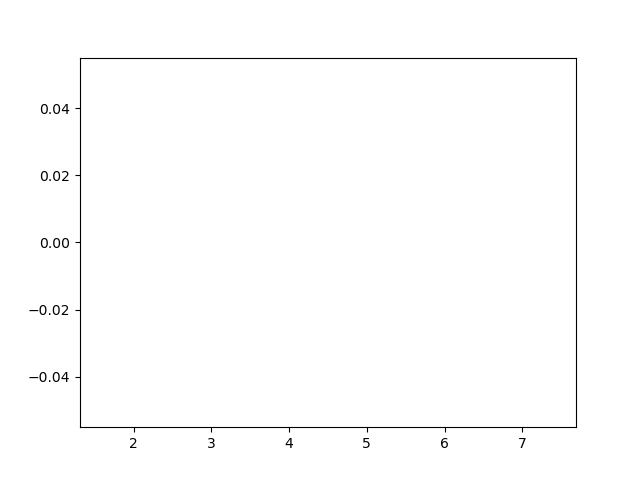

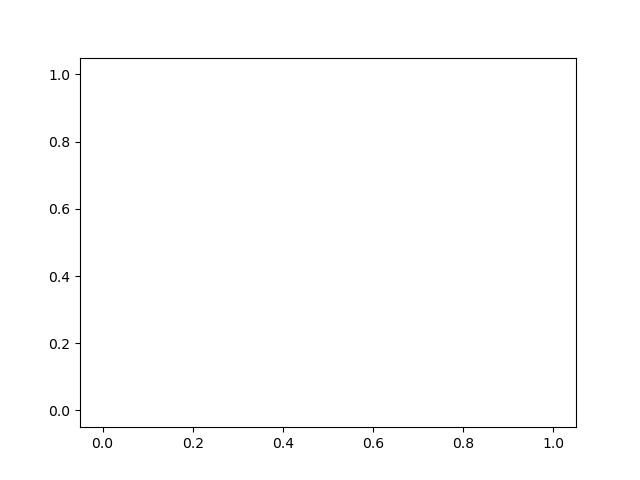

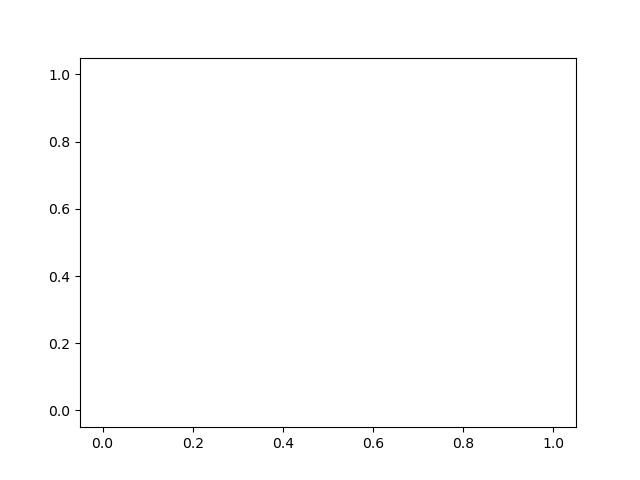

In [8]:
vis = Visualiser() #define an instance of the class Visualiser
sub_odom = rospy.Subscriber('/odom', Odometry, vis.clbk_odom)#define and initialize the subscriber to the 
#topic '/odom'
sub_scan = rospy.Subscriber('/scan', LaserScan, vis.clbk_scan) #define and initialize the subscriber to the
#topic '/scan'
sub_goalstatus = rospy.Subscriber('/goal_status', Bool, vis.clbk_goalstatus) #define and initialize the subscriber to the
#topic '/goal_status'
animation = FuncAnimation(vis.fig1, vis.update_plot1, init_func=vis.plot_init1, frames=100, interval=200, blit=True) 
#consider the figure, initialize the plot, associate the update_plot call-back method to update the plot with the
#FuncAnimation function.[frames: number of frames to be printed (100 by default -> it then restarts if it is not
#specified repeat=False); interval: delay between printed frames in milliseconds (200 by default)]
animation2 = FuncAnimation(vis.fig2, vis.update_plot2, init_func=vis.plot_init2, frames=100, interval=200, blit=True)
animation3 = FuncAnimation(vis.fig3, vis.update_plot3, init_func=vis.plot_init3, frames=100, interval=100, blit=True)
plt.show(block=True) #plot the graphs